# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


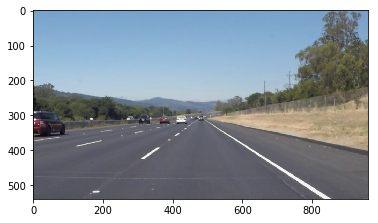

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

The draw_lines() helper function has been modified in this section.

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    right = []
    left = []
    if not isinstance(lines, np.ndarray):
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 == x1:
                continue
            slope = ((y2-y1)/(x2-x1))
            if (abs(slope) < .45):
                continue
            if (slope > 0):
                right.append([[x1,y1,x2,y2, slope]])
            else:
                left.append([[x1,y1,x2,y2, slope]])
            # Display individual line segments
            # if (abs(((y2-y1)/(x2-x1))) > .6):
            #     cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            # elif (abs(((y2-y1)/(x2-x1))) > .45):
            #     cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)
            # else:
            #     cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)
    
    # want a maximum y value intercept based on image shape
    imshape = img.shape
    ymax = imshape[0]
    yhalf = int(.4 * ymax)  # a roughly half of image measure, near the region of interest

    cum = 0
    count = 0
    cum_intercept = 0
    xint = 0
    
    for line in left:
        for x1,y1,x2,y2,slope in line:
            cum += slope
            count +=1
            cum_intercept += y1 - slope*x1
            xint += (ymax - (y1 - slope*x1))/slope

    if count > 0:    
        avg_slope = cum/count
        avg_intercept = int(cum_intercept//count)
        avg_xint = int(xint/count)
        cv2.line(img, (avg_xint, ymax), (int(((ymax-yhalf)-(ymax - avg_slope*avg_xint))/avg_slope), ymax - yhalf), [255, 0, 0], 8)    

    #print ("right lines", right)
    cum = 0
    count = 0
    cum_intercept = 0
    xint = 0

    for line in right:
        for x1,y1,x2,y2,slope in line:
            cum += slope
            count +=1
            cum_intercept += y1 - slope*x1
            xint += (ymax - (y1 - slope*x1))/slope

    if count > 0:
        avg_slope = cum/count
        avg_intercept = int(cum_intercept//count)
        avg_xint = int(xint/count)
        cv2.line(img, (avg_xint, ymax), (int(((ymax-yhalf)-(ymax - avg_slope*avg_xint))/avg_slope), ymax - yhalf), [255, 0, 0], 8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def process_image(image):
    return process_image_explore(image, 150, 220)
    
def process_image_test_canny(image):
    gray = grayscale(image)
    gaussi = gaussian_blur(gray, 5)
    cannyi = canny(gaussi, 150, 220)
    return cannyi

def process_filter_yellow_and_white(image):
    # white
    white_pixels = cv2.inRange(image, np.uint8([220, 220, 200]), np.uint8([255, 255, 255]))
    # yellow
    yellow_pixels = cv2.inRange(image, np.uint8([190, 190,   0]), np.uint8([255, 255, 255]))
    yw_pix = cv2.bitwise_or(white_pixels, yellow_pixels)
    filtered_yw = cv2.bitwise_and(image, image, mask = yw_pix)
    return filtered_yw

def process_image_test_yellow_and_white(image):
    # white
    white_pixels = cv2.inRange(image, np.uint8([220, 220, 200]), np.uint8([255, 255, 255]))
    # yellow
    yellow_pixels = cv2.inRange(image, np.uint8([190, 190,   0]), np.uint8([255, 255, 255]))
    yw_pix = cv2.bitwise_or(white_pixels, yellow_pixels)
    filtered_yw = cv2.bitwise_and(image, image, mask = yw_pix)
    gray = grayscale(filtered_yw)
    gaussi = gaussian_blur(gray, 5)
    cannyi = canny(gaussi, 150, 220)
    imshape = gaussi.shape

    vertices = np.array([[(0,imshape[0]),(.49*imshape[1], .58*imshape[0]), (.51*imshape[1], .58*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)

    roint = region_of_interest(cannyi, vertices)

    rho = 1              # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 7        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 # minimum number of pixels making up a line
    max_line_gap = 35    # maximum gap in pixels between connectable line segments

    hough_out = hough_lines(roint, rho, theta, threshold,
                            min_line_length, max_line_gap)
    result = weighted_img(hough_out, image)

    return result

def process_image_explore(image, canny_low_threshold, canny_high_threshold):

    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(image)
    gaussi = gaussian_blur(gray, 5)

    cannyi = canny(gaussi, canny_low_threshold, canny_high_threshold)
    imshape = gaussi.shape

    vertices = np.array([[(0,imshape[0]),(.49*imshape[1], .58*imshape[0]), (.51*imshape[1], .58*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)

    roint = region_of_interest(cannyi, vertices)
        
    rho = 1              # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 7        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 # minimum number of pixels making up a line
    max_line_gap = 35    # maximum gap in pixels between connectable line segments

    hough_out = hough_lines(roint, rho, theta, threshold,
                            min_line_length, max_line_gap)

    result = weighted_img(hough_out, image)

    return result

## Test images with a range of canny parameters for low and high thresholds


0 110
1 130
2 150
3 170
4 190


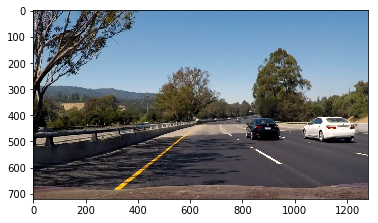

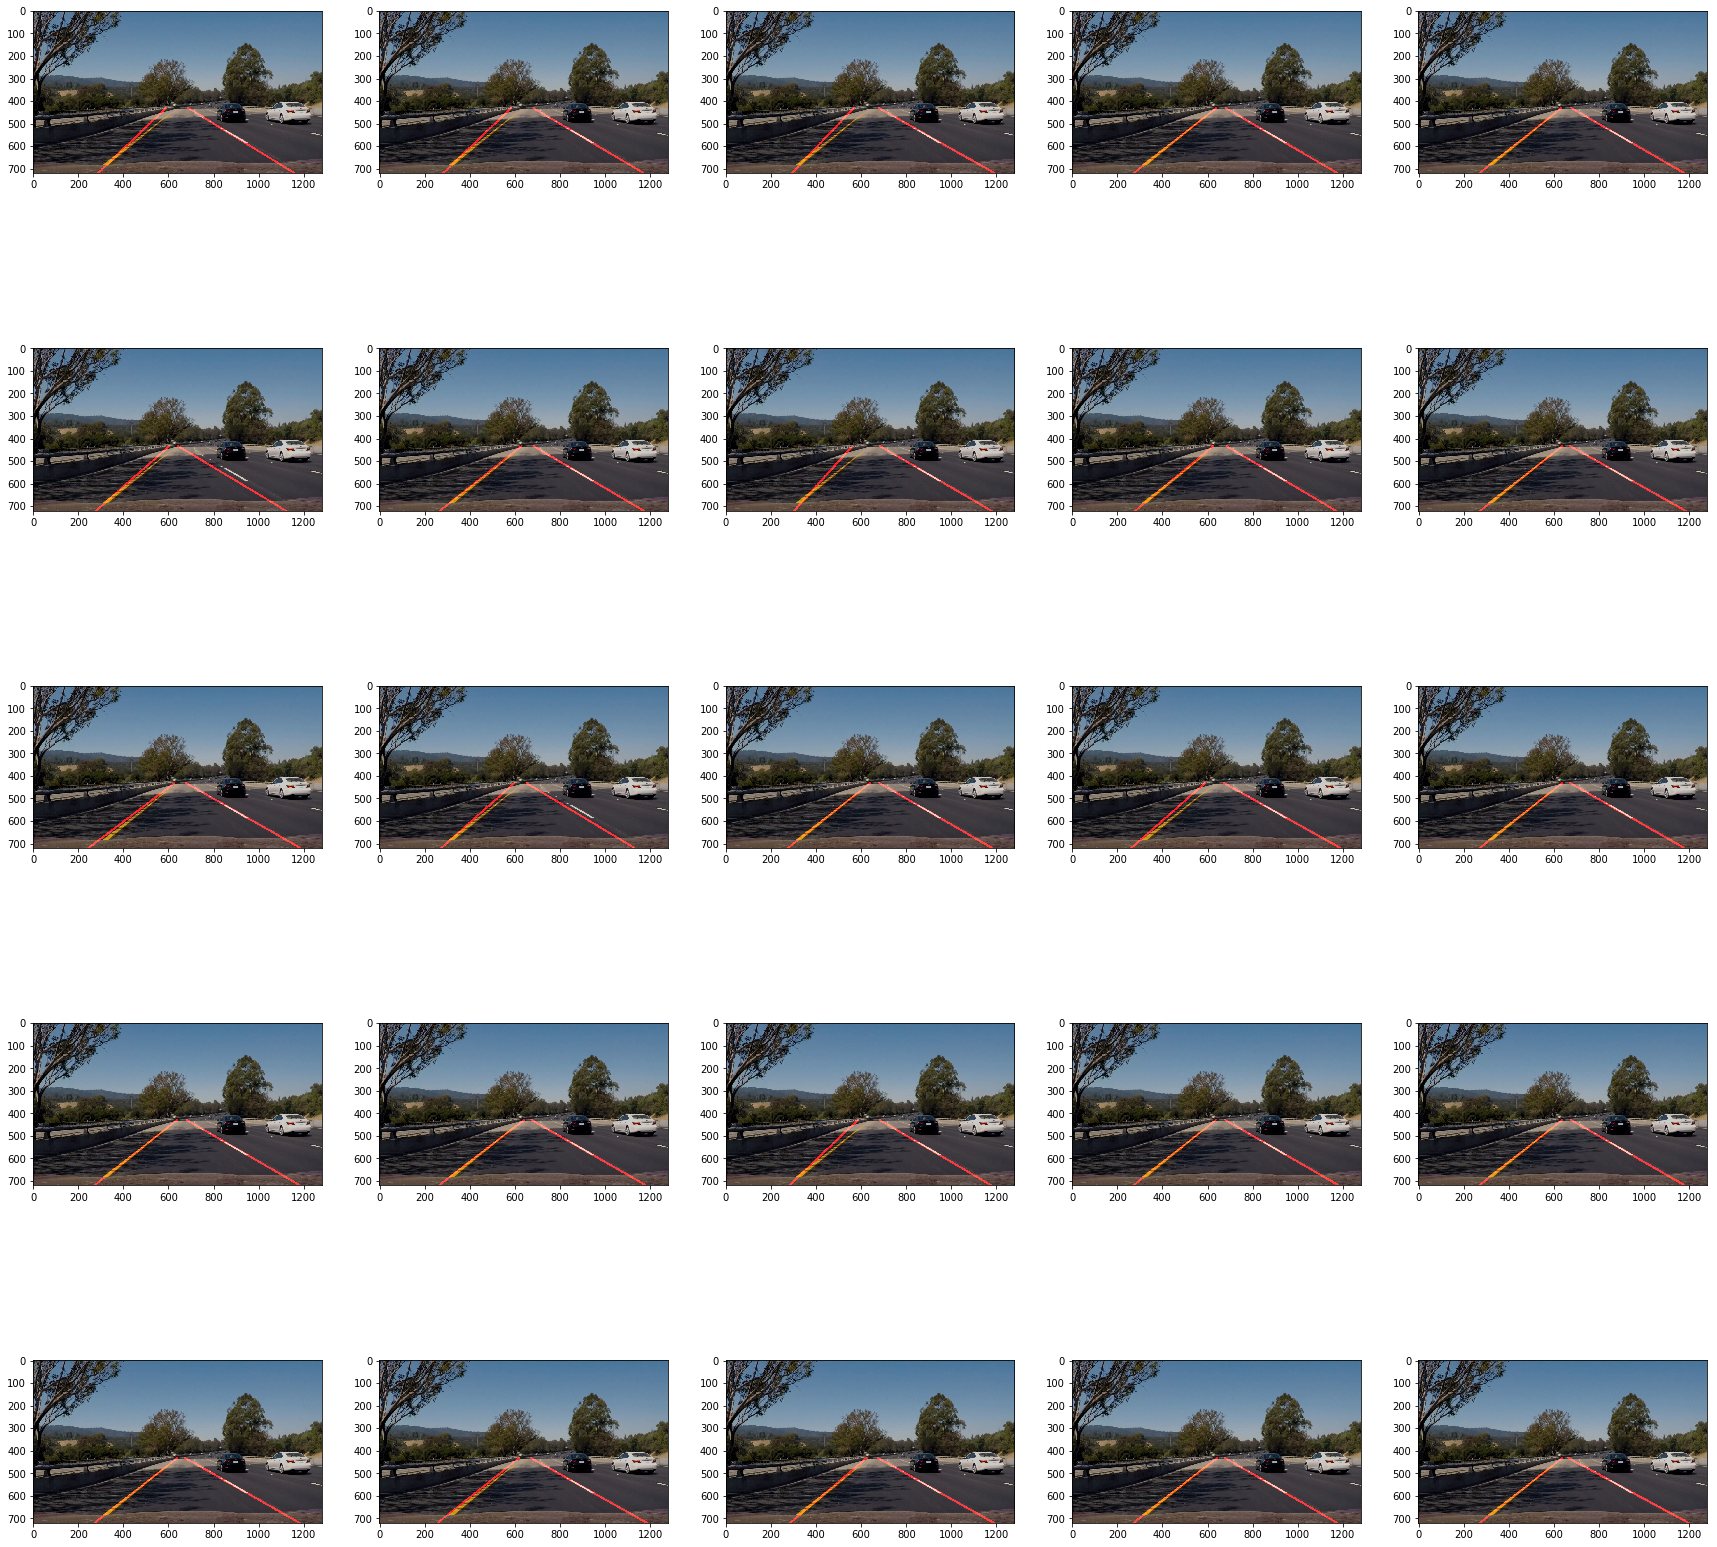

In [6]:
test_image = mpimg.imread("test_images/" + "challenge_shadows.jpg")
plt.figure()
plt.imshow(test_image)

f, axarr = plt.subplots(5, 5, figsize=(30,30))

# 150 looks good for lt, 220 seems good for ht
for y, lt in enumerate(range(110, 191, 20)):
    print (y, lt)
    for x, ht in enumerate(range(160, 241, 20)):
        proc_out_image = process_image_explore(test_image, lt, ht)
        #proc_out_image = process_image(test_image)

        
        axarr[x,y].imshow(proc_out_image)
        

## Helper function for displaying list of images

In [7]:
def show_list_images(images):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot((len(images)+1)//3, 3, i+1)
        plt.imshow(image)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()
 

## Test the yellow and white filter on the test images

['challenge_bridge_yellow.jpg', 'challenge_shadows.jpg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


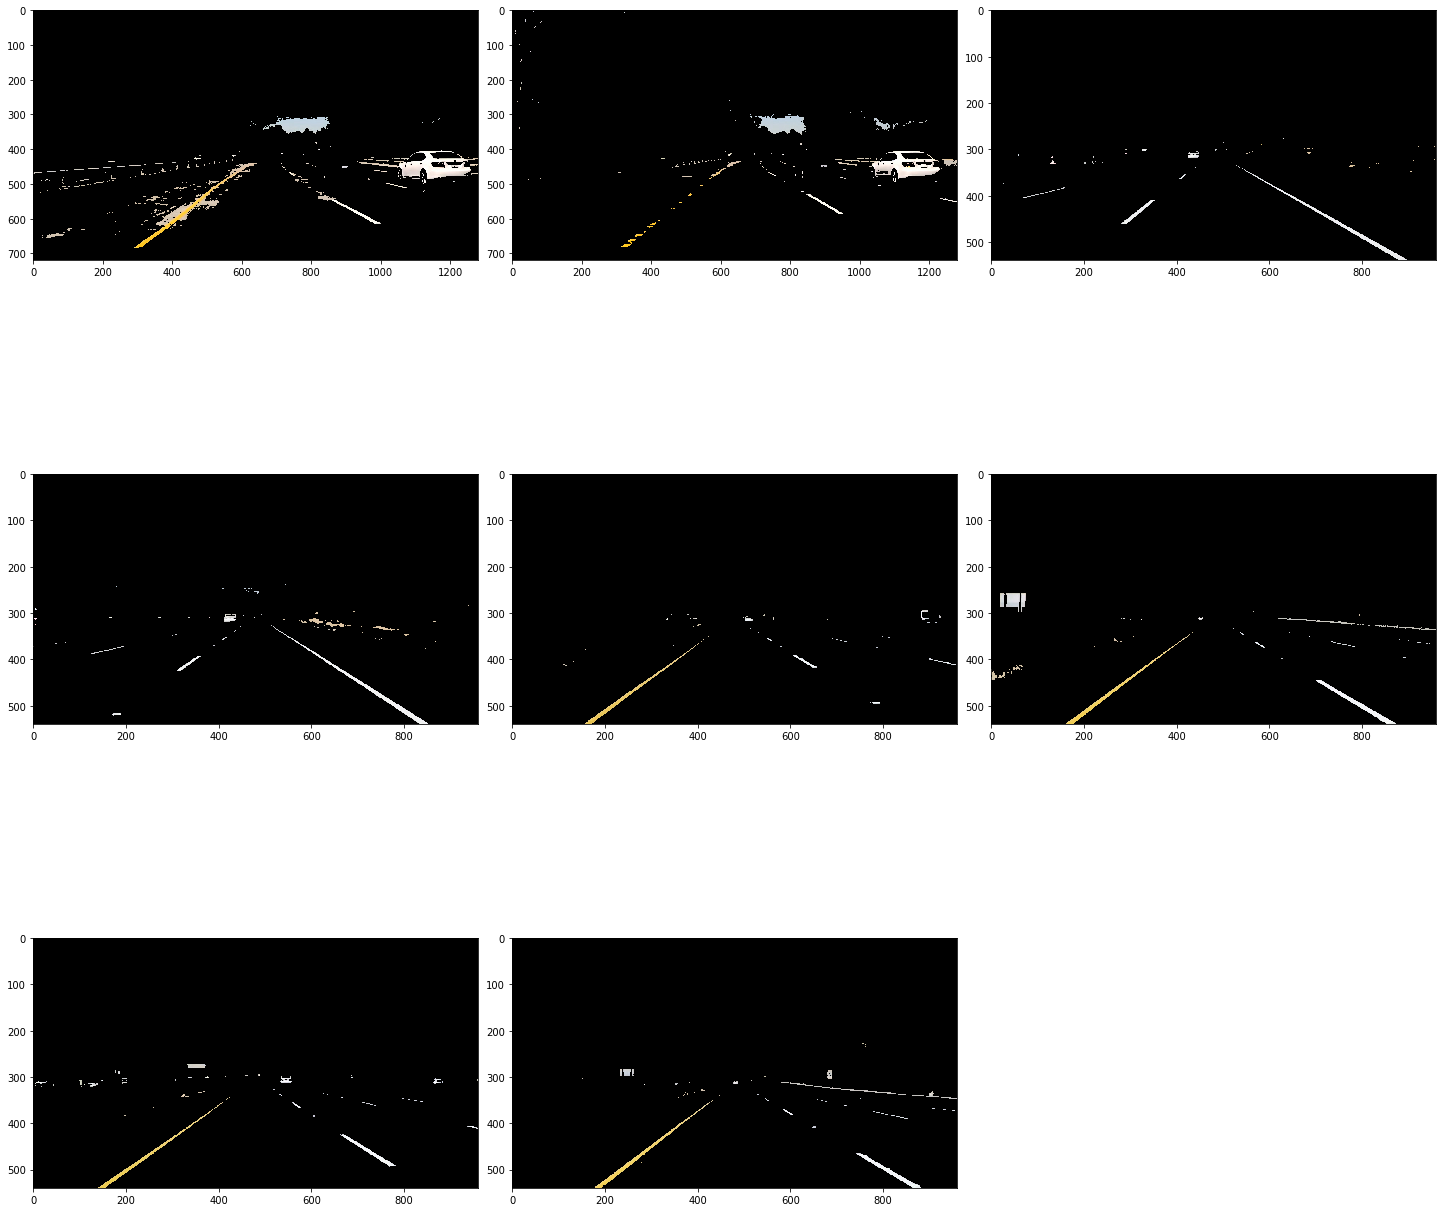

In [8]:
test_image_files = os.listdir("test_images/")
print (test_image_files)
test_image_list = []
out_image_list = []
for test_image_file in test_image_files:
    test_image = mpimg.imread("test_images/" + test_image_file)
    test_image_list.append(test_image)

    proc_out_image = process_filter_yellow_and_white(test_image)
    out_image_list.append(proc_out_image)

#show_list_images(test_image_list)
show_list_images(out_image_list)

## Same yellow and white filter with full pipeline

['challenge_bridge_yellow.jpg', 'challenge_shadows.jpg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


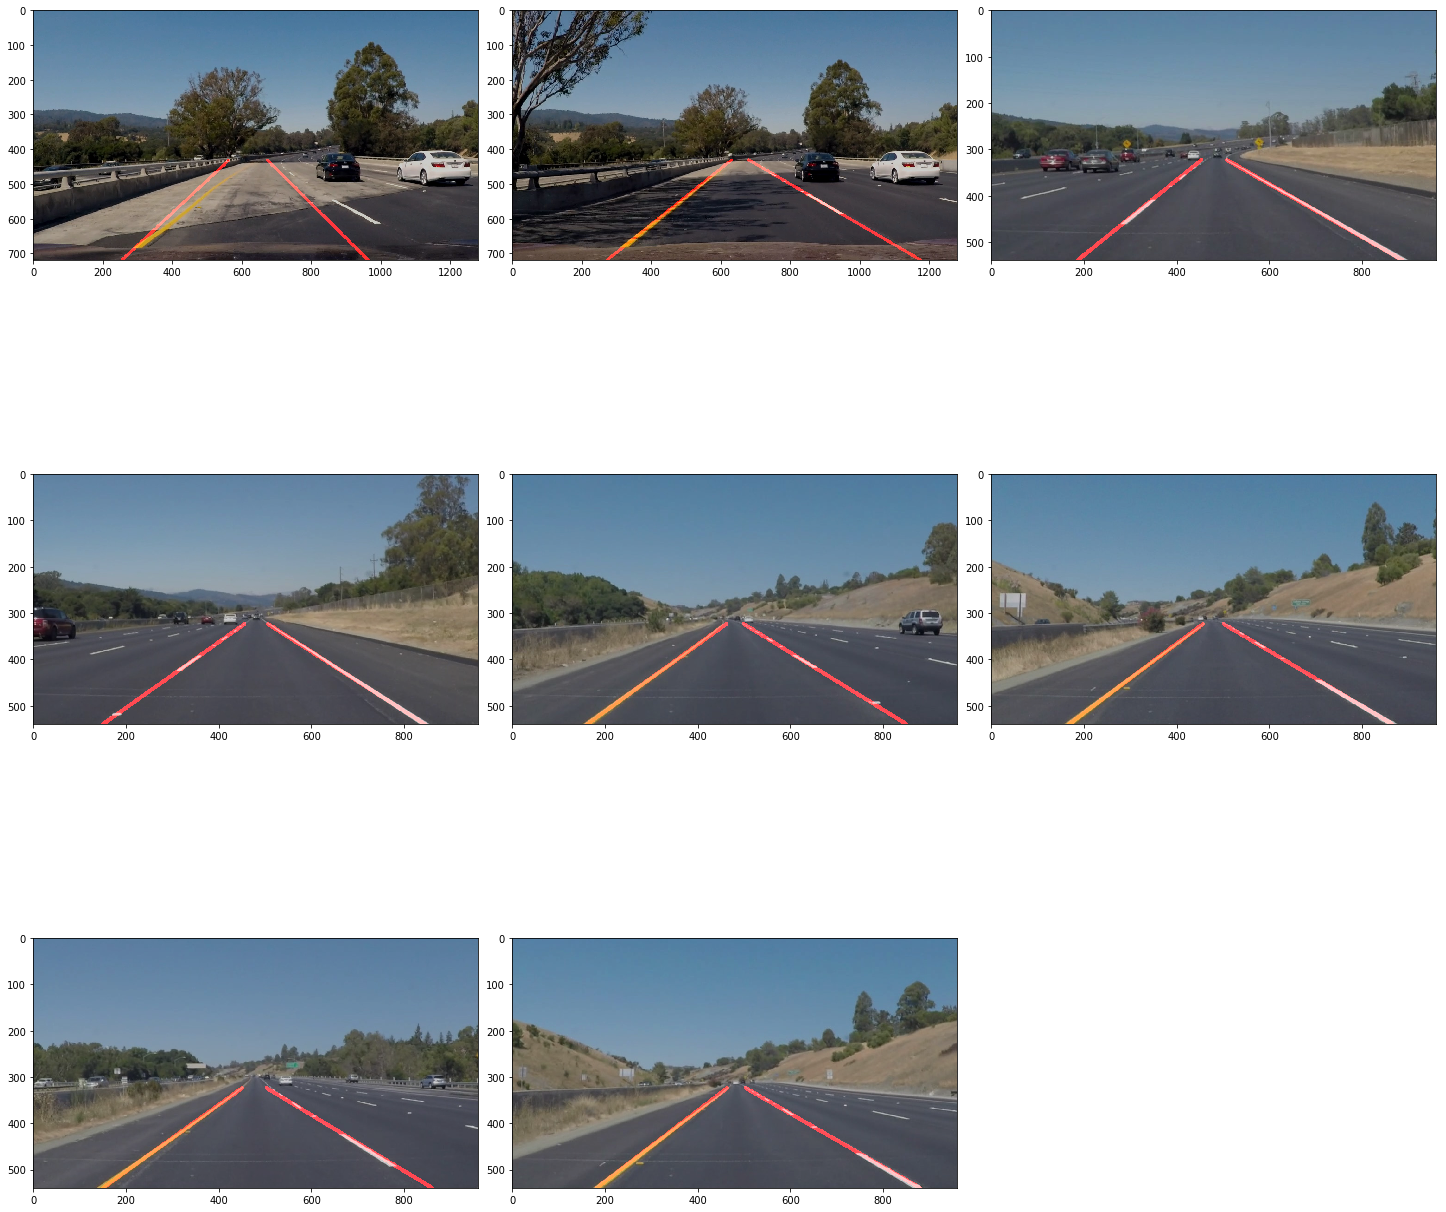

In [9]:
test_image_files = os.listdir("test_images/")
print (test_image_files)
test_image_list = []
out_image_list = []
for test_image_file in test_image_files:
    test_image = mpimg.imread("test_images/" + test_image_file)
    test_image_list.append(test_image)

    proc_out_image = process_image_test_yellow_and_white(test_image)
    out_image_list.append(proc_out_image)

#show_list_images(test_image_list)
show_list_images(out_image_list)

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.47 s, sys: 896 ms, total: 4.37 s
Wall time: 5.04 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:15<00:00, 43.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12 s, sys: 2.94 s, total: 14.9 s
Wall time: 16.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
## clip3 = VideoFileClip('test_videos/challenge.mp4')
clip3 = VideoFileClip('test_videos/challenge.mp4')
#challenge_clip = clip3.fl_image(process_image)
challenge_clip = clip3.fl_image(process_image_test_yellow_and_white)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:12<00:00, 20.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.97 s, sys: 2.48 s, total: 11.4 s
Wall time: 13.9 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))